#  TensorFlow Distributed Training & Inference 

For use cases involving large datasets, particularly those where the data is images, it often is necessary to perform distributed training on a cluster of multiple machines. Similarly, when it is time to set up an inference workflow, it also may be necessary to perform highly performant batch inference using a cluster.  In this notebook, we'll examine distributed training and distributed inference with TensorFlow in Amazon SageMaker. 

The model used for this notebook is a basic Convolutional Neural Network (CNN) based on [the Keras examples](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py).  We'll train the CNN to classify images using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), a well-known computer vision dataset. It consists of 60,000 32x32 images belonging to 10 different classes (6,000 images per class). Here is a graphic of the classes in the dataset, as well as 10 random images from each:

![cifar10](https://maet3608.github.io/nuts-ml/_images/cifar10.png)


## Setup 

We'll begin with some necessary imports, and get an Amazon SageMaker session to help perform certain tasks, as well as an IAM role with the necessary permissions.

In [1]:
%matplotlib inline
import numpy as np
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-tf-horovod-inference'
print('Bucket:\n{}'.format(bucket))

Bucket:
sagemaker-us-west-2-973822232355


Now we'll run a script that fetches the dataset and converts it to the TFRecord format, which provides several conveniences for training models in TensorFlow.

In [2]:
!python generate_cifar10_tfrecords.py --data-dir ./data

Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract.
Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.
Generating ./data/train/train.tfrecords
Generating ./data/validation/validation.tfrecords
Generating ./data/eval/eval.tfrecords
Done!


For Amazon SageMaker hosted training on a cluster separate from this notebook instance, training data must be stored in Amazon S3, so we'll upload the data to S3 now.

In [3]:
inputs = sagemaker_session.upload_data(path='data', key_prefix='data/DEMO-cifar10-tf')
display(inputs)

's3://sagemaker-us-west-2-973822232355/data/DEMO-cifar10-tf'

## Distributed training with Parameter Server

A common pattern in distributed training is to use one or more dedicated processes to collect gradients computed by “worker” processes, then aggregate them and distribute the updated gradients back to the workers in an asynchronous manner. These processes are known as parameter servers. In general, they can be run either on their own machines or co-located on the same machines as the workers. In a parameter server cluster, each parameter server communicates with all workers (“all-to-all”). The Amazon SageMaker prebuilt TensorFlow container comes with a built-in option to use parameter servers for distributed training. The container runs a parameter server thread in each training instance.

Once we have a training script, the next step is to set up an Amazon SageMaker TensorFlow Estimator object with the details of the training job.  It is very similar to an Estimator for training on a single machine, except we specify a `distributions` parameter to enable starting of parameter server in each training instance. 

In [12]:
from sagemaker.tensorflow import TensorFlow

ps_instance_type = 'ml.p3.8xlarge'
ps_instance_count = 2

model_dir = "/opt/ml/model"

distributions = {'parameter-server': {
                    'enabled': True}
                }
hyperparameters = {'epochs': 60, 'batch-size' : 256, 'sagemaker_parameter_server_enabled': True}

estimator_ps = TensorFlow(base_job_name='dist-cifar10-tf',
                       source_dir='code',
                       entry_point='train_ps.py', 
                       role=role,
                       framework_version='1.12.0',
                       py_version='py3',
                       hyperparameters=hyperparameters,
                       train_instance_count=ps_instance_count, 
                       train_instance_type=ps_instance_type,
                       model_dir=model_dir,
                       tags = [{'Key' : 'Project', 'Value' : 'cifar10'},{'Key' : 'TensorBoard', 'Value' : 'dist'}],
                       distributions=distributions)

Now we can call the fit method of the Estimator object to start training. After training completes, the tf.keras model will be saved in the SavedModel .pb format so it can be served by a TensorFlow Serving container. Note that the model is only saved by the the master node (disregard any warnings about the model not being saved by all the processes).

In [13]:
remote_inputs = {'train' : inputs+'/train', 'validation' : inputs+'/validation', 'eval' : inputs+'/eval'}
estimator_ps.fit(remote_inputs, wait=True)

2019-06-01 00:05:20 Starting - Starting the training job...
2019-06-01 00:05:22 Starting - Launching requested ML instances......
2019-06-01 00:06:28 Starting - Preparing the instances for training......
2019-06-01 00:07:51 Downloading - Downloading input data...
2019-06-01 00:08:16 Training - Training image download completed. Training in progress..
2019-06-01 00:08:18,185 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-06-01 00:08:18,235 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2019-06-01 00:08:18,235 sagemaker_tensorflow_container.training INFO     Launching parameter server process
2019-06-01 00:08:18,235 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2019-06-01 00:08:18,508 sagemaker_tensorflow_container.training INFO     Launching worker process
2019-06-01 00:08:18,839 sagemaker-containers INFO     Invoking user sc

INFO:root:configuring model
INFO:root:Hosts: ["algo-1","algo-2"]
INFO:root:Starting training
Epoch 1/60
#015 1/78 [..............................] - ETA: 20:16 - loss: 4.0267 - acc: 0.0898#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 6:36 - loss: 4.0037 - acc: 0.1120 #010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3:52 - loss: 3.7383 - acc: 0.1258#010#010#

#015 1/78 [..............................] - ETA: 14:50 - loss: 3.9091 - acc: 0.0781#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 4:50 - loss: 4.3456 - acc: 0.1081 #010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 2:50 - loss: 3.8595 - acc: 0.1336#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 1s - loss: 1.3580 - acc: 0.5117#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 1s - loss: 1.3111 - acc: 0.5117#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 6/78 [=>............................] - ETA: 1s - loss: 1.3605 - acc: 0.5176#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 1s - loss: 1.0549 - acc: 0.6289#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 1s - loss: 1.0351 - acc: 0.6445#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 1s - loss: 1.0450 - acc: 0.6328#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 1s - loss: 0.9098 - acc: 0.6992#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 4/78 [>.............................] - ETA: 1s - loss: 0.9141 - acc: 0.6914#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 7/78 [=>............................] - ETA: 1s - loss: 0.8960 - acc: 0.6858#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 1s - loss: 0.7331 - acc: 0.7305#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 4/78 [>.............................] - ETA: 1s - loss: 0.7726 - acc: 0.7197#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 7/78 [=>............................] - ETA: 1s - loss: 0.7634 - acc: 0.7282#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 1s - loss: 0.6875 - acc: 0.7500#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 4/78 [>.............................] - ETA: 1s - loss: 0.7031 - acc: 0.7539#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 7/78 [=>............................] - ETA: 1s - loss: 0.7257 - acc: 0.7411#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 1s - loss: 0.6833 - acc: 0.7695#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 4/78 [>.............................] - ETA: 1s - loss: 0.6912 - acc: 0.7734#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 6/78 [=>............................] - ETA: 1s - loss: 0.7107 - acc: 0.7591#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 1s - loss: 0.6128 - acc: 0.7891#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 4/78 [>.............................] - ETA: 1s - loss: 0.6184 - acc: 0.7930#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 7/78 [=>............................] - ETA: 1s - loss: 0.6556 - acc: 0.7807#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 1s - loss: 0.4666 - acc: 0.8477#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 1s - loss: 0.5680 - acc: 0.8164#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 6/78 [=>............................] - ETA: 1s - loss: 0.5796 - acc: 0.8040#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 1s - loss: 0.6566 - acc: 0.7852#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 4/78 [>.............................] - ETA: 1s - loss: 0.5279 - acc: 0.8203#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 6/78 [=>............................] - ETA: 1s - loss: 0.5493 - acc: 0.8184#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 1s - loss: 0.5376 - acc: 0.8398#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 4/78 [>.............................] - ETA: 1s - loss: 0.5368 - acc: 0.8174#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 7/78 [=>............................] - ETA: 1s - loss: 0.5464 - acc: 0.8080#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 1s - loss: 0.6119 - acc: 0.7852#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 4/78 [>.............................] - ETA: 1s - loss: 0.5331 - acc: 0.8164#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 7/78 [=>............................] - ETA: 1s - loss: 0.5260 - acc: 0.8192#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 1s - loss: 0.6315 - acc: 0.8086#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 4/78 [>.............................] - ETA: 1s - loss: 0.5812 - acc: 0.8027#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 7/78 [=>............................] - ETA: 1s - loss: 0.5831 - acc: 0.8002#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 2s - loss: 0.5599 - acc: 0.8242#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 1s - loss: 0.4940 - acc: 0.8451#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 1s - loss: 0.5287 - acc: 0.8313#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#


2019-06-01 00:11:25 Uploading - Uploading generated training model
2019-06-01 00:11:25 Completed - Training job completed
#015 1/78 [..............................] - ETA: 1s - loss: 0.4498 - acc: 0.8477#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 1s - loss: 0.5302 - acc: 0.8190#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 6/78 [=>............................] - ETA: 1s - loss: 0.5118 - acc: 0.8307#010#010#010#010#0

Billable seconds: 429


## Distributed training with Horovod

Sometimes it makes sense to perform training on a single machine. For large datasets, however, it may be necessary to perform distributed training on a cluster of multiple machines. In fact, it may be not only faster but cheaper to do distributed training on several machines rather than one machine. Fortunately, Amazon SageMaker makes it easy to run distributed training without having to manage cluster setup and tear down.  Distributed training can be done on a cluster of multiple machines using either parameter servers or Ring-AllReduce with Horovod. 

Horovod is an open source distributed training framework for TensorFlow, Keras, PyTorch, and MXNet. It is an alternative to the more "traditional" parameter server method of performing distributed training.  In Amazon SageMaker, Horovod is only available with TensorFlow version 1.12 or newer. Only a few lines of code are necessary to use Horovod for distributed training of a Keras model defined by the tf.keras API.  For details, see the `train.py` script included with this notebook; the changes primarily relate to:

- importing Horovod.
- initializing Horovod.
- configuring GPU options and setting a Keras/tf.session with those options.

Once we have a training script, the next step is to set up an Amazon SageMaker TensorFlow Estimator object with the details of the training job.  It is very similar to an Estimator for training on a single machine, except we specify a `distributions` parameter describing Horovod attributes such as the number of process per host, which is set here to the number of GPUs per machine.  Beyond these few simple parameters and the few lines of code in the training script, there is nothing else you need to do to use distributed training with Horovod; Amazon SageMaker handles the heavy lifting for you and manages the underlying cluster setup.

In [20]:
from sagemaker.tensorflow import TensorFlow

hvd_instance_type = 'ml.p3.8xlarge'
hvd_processes_per_host = 4
hvd_instance_count = 2

distributions = {'mpi': {
                    'enabled': True,
                    'processes_per_host': hvd_processes_per_host
                        }
                }
hyperparameters = {'epochs': 60, 'batch-size' : 256}

estimator_hvd = TensorFlow(base_job_name='dist-cifar10-tf',
                       source_dir='code',
                       entry_point='train_hvd.py', 
                       role=role,
                       framework_version='1.12.0',
                       py_version='py3',
                       hyperparameters=hyperparameters,
                       train_instance_count=hvd_instance_count, 
                       train_instance_type=hvd_instance_type,
                       tags = [{'Key' : 'Project', 'Value' : 'cifar10'},{'Key' : 'TensorBoard', 'Value' : 'dist'}],
                       distributions=distributions)

Now we can call the `fit` method of the Estimator object to start training. After training completes, the tf.keras model will be saved in the SavedModel .pb format so it can be served by a TensorFlow Serving container.  Note that the model is only saved by the the master, rank = 0 process (disregard any warnings about the model not being saved by all the processes).

In [21]:
remote_inputs = {'train' : inputs+'/train', 'validation' : inputs+'/validation', 'eval' : inputs+'/eval'}
estimator_hvd.fit(remote_inputs, wait=True)

2019-06-01 04:30:00 Starting - Starting the training job...
2019-06-01 04:30:01 Starting - Launching requested ML instances......
2019-06-01 04:31:08 Starting - Preparing the instances for training......
2019-06-01 04:32:17 Downloading - Downloading input data
2019-06-01 04:32:17 Training - Downloading the training image.....
2019-06-01 04:33:05,356 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-06-01 04:33:05,666 sagemaker-containers INFO     Starting MPI run as worker node.
2019-06-01 04:33:05,666 sagemaker-containers INFO     Waiting for MPI Master to create SSH daemon.
2019-06-01 04:33:05,667 sagemaker-containers INFO     Cannot connect to host algo-1
2019-06-01 04:33:05,667 sagemaker-containers INFO     Connection failed with exception: 
 [Errno -2] Name or service not known
2019-06-01 04:33:06,669 sagemaker-containers INFO     Cannot connect to host algo-1
2019-06-01 04:33:06,669 sagemaker-containers INFO     Connection failed with e

[1,2]<stderr>:[algo-1:00106] Read -1, expected 8192, errno = 1
[1,1]<stderr>:[algo-1:00105] Read -1, expected 8192, errno = 1
[1,3]<stderr>:[algo-1:00107] Read -1, expected 8192, errno = 1
[1,2]<stderr>:[algo-1:00106] Read -1, expected 8192, errno = 1
[1,1]<stderr>:[algo-1:00105] Read -1, expected 8192, errno = 1
[1,2]<stderr>:[algo-1:00106] Read -1, expected 8192, errno = 1
[1,3]<stderr>:[algo-1:00107] Read -1, expected 8192, errno = 1
[1,1]<stderr>:[algo-1:00105] Read -1, expected 8192, errno = 1
[1,2]<stderr>:[algo-1:00106] Read -1, expected 8192, errno = 1
[1,1]<stderr>:[algo-1:00105] Read -1, expected 8192, errno = 1
[1,3]<stderr>:[algo-1:00107] Read -1, expected 8192, errno = 1
[1,2]<stderr>:[algo-1:00106] Read -1, expected 8192, errno = 1
[1,1]<stderr>:[algo-1:00105] Read -1, expected 8192, errno = 1
[1,3]<stderr>:[algo-1:00107] Read -1, expected 8192, errno = 1
[1,2]<stderr>:[algo-1:00106] Read -1, expected 8192, errno = 1
[1,1]<stderr>:[algo-1:00105] Read -1, expected 8192, er


2019-06-01 04:33:04 Training - Training image download completed. Training in progress.[1,0]<stdout>:
[1,0]<stdout>:algo-1:104:395 [0] misc/ibvwrap.cu:63 NCCL WARN Failed to open libibverbs.so[.1]
[1,0]<stdout>:algo-1:104:395 [0] NCCL INFO Using internal Network Socket
[1,0]<stdout>:algo-1:104:395 [0] NCCL INFO NET : Using interface ethwe:10.40.0.2<0>
[1,0]<stdout>:algo-1:104:395 [0] NCCL INFO NET/Socket : 1 interfaces found
[1,0]<stdout>:NCCL version 2.3.5+cuda9.0
[1,0]<stdout>:algo-1:104:395 [0] NCCL INFO rank 0 nranks 8
[1,3]<stdout>:
[1,3]<stdout>:algo-1:107:394 [3] misc/ibvwrap.cu:63 NCCL WARN Failed to open libibverbs.so[.1]
[1,3]<stdout>:algo-1:107:394 [3] NCCL INFO Using internal Network Socket
[1,2]<stdout>:
[1,2]<stdout>:algo-1:106:392 [2] misc/ibvwrap.cu:63 NCCL WARN Failed to open libibverbs.so[.1]
[1,2]<stdout>:algo-1:106:392 [2] NCCL INFO Using internal Network Socket
[1,3]<stdout>:algo-1:107:394 [3] NCCL INFO rank 3 nranks 8
[1,1]<stdout>:
[1,1]<stdout>:algo-1:105:393 [

[1,1]<stdout>:#015[1,1]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 1.3979 - acc: 0.4766[1,2]<stdout>:#015[1,3]<stdout>:#015[1,2]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 1.3510 - acc: 0.4922[1,0]<stdout>:#015[1,3]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 1.5479 - acc: 0.4297[1,0]<stdout>: 1/19 [>.............................] - ETA: 0s - loss: 1.4748 - acc: 0.4492[1,7]<stdout>:#015[1,6]<stdout>:#015[1,7]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 1.4101 - acc: 0.4805[1,6]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 1.2855 - acc: 0.5430[1,4]<stdout>:#015[1,5]<stdout>:#015[1,4]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 1.2880 - acc: 0.5273[1,5]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 1.4861 - acc: 0.4453[1,7]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:19/19 [==============================] - 2s 92ms/step - loss: 0.9702 - acc: 0.6481 - val_loss: 1.1086 - val_acc: 0.6198
[1,0]<stdout>:Epoch 11/60
[1,7]<stdout>:#015[1,5]<stdout>:#015[1,7]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.9650 - acc: 0.6758[1,5]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.9275 - acc: 0.6719[1,6]<stdout>:#015[1,6]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.9793 - acc: 0.6445[1,4]<stdout>:#015[1,4]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.9532 - acc: 0.6523[1,2]<stdout>:#015[1,2]<stdout>: 1/19 [>.............................] - ETA: 

.7298[1,3]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,3]<stdout>:13/19 [===================>..........] - ETA: 0s - loss: 0.8135 - acc: 0.7188[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:13/19 [===================>..........] - ETA: 0s - loss: 0.8001 - acc: 0.7227[1,7]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01

[1,7]<stdout>:#015[1,7]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.6931 - acc: 0.7539[1,1]<stdout>:#015[1,1]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.6855 - acc: 0.7500[1,6]<stdout>:#015[1,6]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.5977 - acc: 0.8008[1,2]<stdout>:#015[1,2]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.6406 - acc: 0.7930[1,5]<stdout>:#015[1,5]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.6298 - acc: 0.7773[1,0]<stdout>:#015[1,0]<stdout>: 1/19 [>.............................] - ETA: 0s - loss: 0.6183 - acc: 0.7695[1,3]<stdout>:#015[1,3]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.6067 - acc: 0.7773[1,4]<stdout>:#015[1,4]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.6559 - acc: 0.7539[1,3]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

[1,2]<stdout>:#015[1,3]<stdout>:#015[1,1]<stdout>:#015[1,2]<stdout>: 1/19 [>.............................] - ETA: 6s - loss: 0.6500 - acc: 0.7773[1,1]<stdout>: 1/19 [>.............................] - ETA: 6s - loss: 0.6247 - acc: 0.7930[1,3]<stdout>: 1/19 [>.............................] - ETA: 6s - loss: 0.5981 - acc: 0.7852[1,7]<stdout>:#015[1,7]<stdout>: 1/19 [>.............................] - ETA: 6s - loss: 0.5774 - acc: 0.8125[1,5]<stdout>:#015[1,6]<stdout>:#015[1,5]<stdout>: 1/19 [>.............................] - ETA: 6s - loss: 0.5867 - acc: 0.7852[1,6]<stdout>: 1/19 [>.............................] - ETA: 6s - loss: 0.5720 - acc: 0.8125[1,0]<stdout>:#015[1,0]<stdout>: 1/19 [>.............................] - ETA: 0s - loss: 0.6625 - acc: 0.7539[1,4]<stdout>:#015[1,4]<stdout>: 1/19 [>.............................] - ETA: 6s - loss: 0.5969 - acc: 0.7930[1,3]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

.5254 - acc: 0.8122[1,6]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,6]<stdout>:12/19 [=================>............] - ETA: 0s - loss: 0.5361 - acc: 0.8219[1,4]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,4]<stdout>:12/19 [=================>............] - ETA: 0s - loss: 0.5367 - acc: 0.8148[1,5]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

[1,2]<stdout>:#015[1,3]<stdout>:#015[1,2]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.4696 - acc: 0.8164[1,3]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.4837 - acc: 0.8359[1,0]<stdout>:#015[1,0]<stdout>: 1/19 [>.............................] - ETA: 0s - loss: 0.4891 - acc: 0.8281[1,7]<stdout>:#015[1,6]<stdout>:#015[1,7]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.5254 - acc: 0.7852[1,4]<stdout>:#015[1,6]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.4835 - acc: 0.8359[1,1]<stdout>:#015[1,4]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.4789 - acc: 0.8359[1,1]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.4437 - acc: 0.8594[1,5]<stdout>:#015[1,5]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.5661 - acc: 0.7930[1,3]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

[1,2]<stdout>:#015[1,2]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.4107 - acc: 0.8711[1,3]<stdout>:#015[1,3]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.4342 - acc: 0.8320[1,7]<stdout>:#015[1,7]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.5143 - acc: 0.8320[1,5]<stdout>:#015[1,5]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.5357 - acc: 0.8125[1,1]<stdout>:#015[1,4]<stdout>:#015[1,1]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.5412 - acc: 0.8086[1,4]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.5060 - acc: 0.8008[1,0]<stdout>:#015[1,0]<stdout>: 1/19 [>.............................] - ETA: 0s - loss: 0.4120 - acc: 0.8359[1,6]<stdout>:#015[1,6]<stdout>: 1/19 [>.............................] - ETA: 5s - loss: 0.5066 - acc: 0.8125[1,7]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:19/19 [==============================] - 2s 93ms/step - loss: 0.4303 - acc: 0.8563 - val_loss: 0.6174 - val_acc: 0.8057
[1,0]<stdout>:Epoch 51/60
[1,7]<stdout>:#015[1,6]<stdout>:#015[1,7]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.4769 - acc: 0.8398[1,6]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.4926 - acc: 0.8242[1,2]<stdout>:#015[1,2]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.4328 - acc: 0.8555[1,1]<stdout>:#015[1,4]<stdout>:#015[1,1]<stdout>: 1/19 [>.............................] - ETA: 4s - loss: 0.4719 - acc: 0.8438[1,4]<stdout>: 1/19 [>.............................] - ETA: 

.8620[1,2]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01512/19 [=================>............] - ETA: 0s - loss: 0.3984 - acc: 0.8600[1,3]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,3]<stdout>:12/19 [=================>............] - ETA: 0s - loss: 0.4030 - acc: 0.8617[1,6]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

[1,0]<stderr>:INFO:root:Model successfully saved at: /opt/ml/model
2019-06-01 04:35:27,533 sagemaker-containers INFO     Reporting training SUCCESS

2019-06-01 04:36:04 Uploading - Uploading generated training model
2019-06-01 04:36:04 Completed - Training job completed
2019-06-01 04:35:57,539 sagemaker-containers INFO     MPI process finished.
2019-06-01 04:35:57,540 sagemaker_tensorflow_container.training WARNING  Your model will NOT be servable with SageMaker TensorFlow Serving container.The model artifact was not saved in the TensorFlow SavedModel directory structure:
https://www.tensorflow.org/guide/saved_model#structure_of_a_savedmodel_directory
2019-06-01 04:35:57,540 sagemaker-containers INFO     Reporting training SUCCESS
Billable seconds: 471


## Model Deployment with Amazon Elastic Inference

Amazon SageMaker provides both real time inference and batch inference.  Although we will focus on batch inference below, let's start with a quick overview of setting up an Amazon SageMaker hosted endpoint for real time inference with TensorFlow Serving (TFS).  The processes for setting up hosted endpoints and Batch Transform jobs have significant differences.  Additionally, we will discuss why and how to use Amazon Elastic Inference with the hosted endpoint.

### Deploying the Model

When considering the overall cost of a machine learning workload, inference often is the largest part, up to 90% of the total.  If a GPU instance type is used for real time inference, it typically is not fully utilized because, unlike training, real time inference does not involve continuously inputting large batches of data to the model.  Elastic Inference provides GPU acceleration suited for inference, allowing you to add inference acceleration to a hosted endpoint for a fraction of the cost of using a full GPU instance.

The `deploy` method of the Estimator object creates an endpoint which serves prediction requests in near real time.  To utilize Elastic Inference with the SageMaker TFS container, simply provide an `accelerator_type` parameter, which determines the type of accelerator that is attached to your endpoint. Refer to the **Inference Acceleration** section of the [instance types chart](https://aws.amazon.com/sagemaker/pricing/instance-types) for a listing of the supported types of accelerators. 

Here we'll use a general purpose CPU compute instance type along with an Elastic Inference accelerator:  together they are much cheaper than the smallest P3 GPU instance type.

In [22]:
predictor = estimator_hvd.deploy(initial_instance_count=1,
                                  instance_type='ml.m5.xlarge',
                                  accelerator_type='ml.eia1.medium')

-------------------------------------------------------------------------------!

###  Real time inference
  
Now that we have a Predictor object wrapping a real time Amazon SageMaker hosted enpoint, we'll define the label names and look at a sample of 10 images, one from each class.

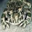

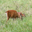

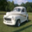

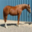

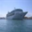

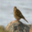

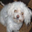

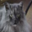

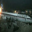

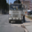

In [23]:
from IPython.display import Image, display

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
images = []
for entry in os.scandir('sample-img'):
    if entry.is_file() and entry.name.endswith("png"):
        images.append('sample-img/' + entry.name)

for image in images:
    display(Image(image))

Next we'll set up the Predictor object created by the `deploy` method call above.  The TFS container in Amazon SageMaker by default uses the TFS REST API, which requires requests in a specific JSON format.  However, for many use cases involving image data it is more convenient to have the client application send the image data directly to a real time endpoint for predictions without converting and preprocessing it on the cliet side. 

Fortunately, the Amazon SageMaker TFS container provides a data pre/post-processing feature that allows you to simply supply a data transformation script to to accomplish this.  We'll discuss this feature more in the Batch Transform section of this notebook.  For now, observe in the code cell below that with a preprocessing script in place, we just specify the Predictor's content type as `application/x-image` and override the default serializer, then we can simply provide the raw .png image bytes to the Predictor.  

In [24]:
predictor.content_type = 'application/x-image'
predictor.serializer = None

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def get_prediction(file_path):
    
    with open(file_path, "rb") as image:
        f = image.read()
    b = bytearray(f)
    return labels[np.argmax(predictor.predict(b)['predictions'], axis=1)[0]]

In [25]:
predictions = [get_prediction(image) for image in images]
print(predictions)

['frog', 'deer', 'automobile', 'horse', 'ship', 'bird', 'dog', 'cat', 'ship', 'truck']


##  Batch Transform with TFS pre/post-processing scripts

If a use case does not require individual predictions in near real-time, an Amazon SageMaker Batch Transform job is likely a better alternative. Although hosted endpoints also can be used for pseudo-batch prediction, the process is more involved than using the alternative Batch Transform, which is designed for large-scale, asynchronous batch inference.

A typical problem in working with batch inference is how to convert data into tensors that can be input to the model.  For example, image data in .png or .jpg format cannot be directly input to a model, but rather must be converted first.  Additionally, sometimes other preprocessing of the data must be performed, such as resizing.  The Amazon SageMaker TFS container provides facilities for doing this efficiently.  

### Pre/post-postprocessing script

As mentioned above, the TFS container in Amazon SageMaker by default uses the REST API to serve prediction requests. This requires the input data to be converted to JSON format.  One way to do this is to create a Docker container to do the conversion, then create an overall Amazon SageMaker model that links the conversion container to the TensorFlow Serving container with the model. This is known as an Amazon SageMaker Inference Pipeline, as demonstrated in another [sample notebook](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/advanced_functionality/working_with_tfrecords).  

However, as a more convenient alternative for many use cases, the Amazon SageMaker TFS container provides a data pre/post-processing script feature that allows you to simply supply a data transformation script.  Using such a script, there is no need to build containers or directly work with Docker.  The simplest form of a script must only implement an `input_handler` and `output_handler` interface, as shown in the code below, be named `inference.py`, and be placed in a `/code` directory.

In [26]:
!cat ./code/inference.py

# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.

import io
import json
import numpy as np
from collections import namedtuple
from PIL import Image

Context = namedtuple('Context',
                     'model_name, model_version, method, rest_uri, grpc_uri, '
                     'custom_attributes, request_content_type, accept_header')


def input_handler(data, context):
    """ Pre-process request input before it is sent to TensorFlow Serving REST API

    Args:
        data (o

On the input preprocessing side, the code takes an image read from Amazon S3 and converts it to the required TFS REST API input format.  On the output postprocessing side, the script simply passes through the predictions in the standard TFS format without modifying them. Alternatively, we could have just returned a class label for the class with the highest score, or performed other postprocessing that would be helpful to the application consuming the predictions. 

### Requirements.txt

Besides an `inference.py` script implementing the handler interface, it also may be necessary to supply a `requirements.txt` file to ensure any necessary dependencies are installed in the container along with the script.  For this script, in addition to the Python standard libraries we need the Pillow and Numpy libraries.

In [27]:
!cat ./code/requirements.txt

Pillow
numpy


### Create GPU Model

When we deployed the model above to an Amazon SageMaker real time endpoint, we deployed to a CPU-based instance type, along with an attached Elastic Inference accelerator to which parts of the model computation graph are offloaded.  Under the hood a CPU-based Amazon SageMaker Model object was created to wrap a CPU-based TFS container.  However, for Batch Transform on a large dataset, we would prefer to use full GPU instances.  To do this, we need to create another Model object that will utilize a GPU-based TFS container.  

In [29]:
import boto3
from sagemaker.tensorflow.serving import Model
from time import gmtime, strftime

client = boto3.client('sagemaker')
model_name = "dist-cifar10-tf-gpu-{}".format(strftime("%d-%H-%M-%S", gmtime()))
estimator = estimator_hvd
tf_serving_model = Model(model_data=estimator.model_data,
                         role=sagemaker.get_execution_role(),
                         image=estimator.image_name,
                         framework_version=estimator.framework_version,
                         sagemaker_session=estimator.sagemaker_session)

batch_instance_type = 'ml.p3.2xlarge'
tf_serving_container = tf_serving_model.prepare_container_def(batch_instance_type)
model_params = {
    "ModelName": model_name,
    "Containers": [
        tf_serving_container
    ],
    "ExecutionRoleArn": sagemaker.get_execution_role()
}

client.create_model(**model_params)

{'ModelArn': 'arn:aws:sagemaker:us-west-2:973822232355:model/dist-cifar10-tf-gpu-02-05-35-52',
 'ResponseMetadata': {'RequestId': '591abc2c-7175-46b3-94d9-039a0f61d0d0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '591abc2c-7175-46b3-94d9-039a0f61d0d0',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '93',
   'date': 'Sun, 02 Jun 2019 05:35:53 GMT'},
  'RetryAttempts': 0}}

### Run a Batch Transform job

Next, we'll run a Batch Transform job using our data processing script and GPU-based Amazon SageMaker Model. More specifically, we'll perform distributed inference on a cluster of two instances.  As an additional optimization, we'll set the `max_concurrent_transforms` parameter of the Transformer object, which controls the maximum number of parallel requests that can be sent to each instance in a transform job.

In [30]:
input_data_path = 's3://sagemaker-sample-data-{}/tensorflow/cifar10/images/png'.format(sagemaker_session.boto_region_name)
output_data_path = 's3://{}/{}/{}'.format(bucket, prefix, 'batch-predictions')
batch_instance_count = 2
concurrency = 100

transformer = sagemaker.transformer.Transformer(
    model_name = model_name,
    instance_count = batch_instance_count,
    instance_type = batch_instance_type,
    max_concurrent_transforms = concurrency,
    strategy = 'MultiRecord',
    output_path = output_data_path,
    assemble_with= 'Line',
    base_transform_job_name='cifar-10-image-transform',
    sagemaker_session=sagemaker_session,
)

transformer.transform(data = input_data_path, content_type = 'application/x-image')
transformer.wait()

........................................................!


### Inspect Batch Transform output

Finally, we can inspect the output files of our Batch Transform job to see the predictions.  First we'll download the prediction files locally, then extract the predictions from them.

In [31]:
!aws s3 cp --quiet --recursive $transformer.output_path ./batch_predictions

In [32]:
import json
import re

total = 0
correct = 0
predicted = []
actual = []

for entry in os.scandir('batch_predictions'):
    try:
        if entry.is_file() and entry.name.endswith("out"):
            with open(entry, 'r') as f:
                jstr = json.load(f)
                results = [float('%.3f'%(item)) for sublist in jstr['predictions'] for item in sublist]
                class_index = np.argmax(np.array(results))
                predicted_label = labels[class_index]
                predicted.append(predicted_label)
                actual_label = re.search('([a-zA-Z]+).png.out', entry.name).group(1)
                actual.append(actual_label)
                is_correct = (predicted_label in entry.name) or False
                if is_correct:
                    correct += 1
                total += 1
    except Exception as e:
        print(e)
        continue

Let's calculate the accuracy of the predictions.  

In [33]:
print('Out of {} total images, accurate predictions were returned for {}'.format(total, correct))
accuracy = correct / total
print('Accuracy is {:.1%}'.format(accuracy))

Out of 10000 total images, accurate predictions were returned for 8693
Accuracy is 86.9%


The accuracy from the batch transform job on 10000 test images never seen during training is fairly close to the accuracy achieved during training on the validation set.  This is an indication that the model is not overfitting and should generalize fairly well to other unseen data. 

Next we'll plot a confusion matrix, which is a tool for visualizing the performance of a multiclass model. It has entries for all possible combinations of correct and incorrect predictions, and shows how often each one was made by our model. Ours will be row-normalized: each row sums to one, so that entries along the diagonal correspond to recall. 

Text(0.5,1,'Confusion Matrix')

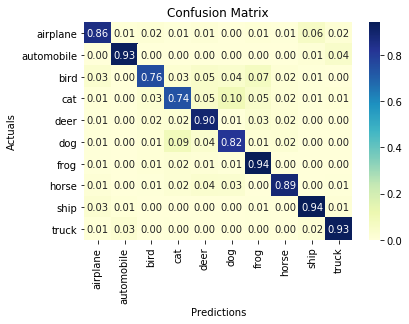

In [34]:
import pandas as pd
import seaborn as sns

confusion_matrix = pd.crosstab(pd.Series(actual), pd.Series(predicted), rownames=['Actuals'], colnames=['Predictions'], normalize='index')
sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  

If our model had 100% accuracy, and therefore 100% recall in every class, then all of the predictions would fall along the diagonal of the confusion matrix.  Here our model definitely is not 100% accurate, but manages to achieve good recall for most of the classes, though it performs worse for some classes, such as cats.  

# Extensions

Although we did not demonstrate them in this notebook, Amazon SageMaker provides additional ways to make distributed training more efficient for very large datasets:
- **VPC training**:  performing Horovod training inside a VPC improves the network latency between nodes, leading to higher performance and stability of Horovod training jobs.

- **Pipe Mode**:  using [Pipe Mode](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html#your-algorithms-training-algo-running-container-inputdataconfig) reduces startup and training times.  Pipe Mode streams training data from S3 as a Linux FIFO directly to the algorithm, without saving to disk.  For a small dataset such as CIFAR-10, Pipe Mode does not provide any advantage, but for very large datasets where training is I/O bound rather than CPU/GPU bound, Pipe Mode can substantially reduce startup and training times.

# Cleanup

To avoid incurring charges due to a stray endpoint, delete the Amazon SageMaker endpoint if you no longer need it:

In [35]:
sagemaker_session.delete_endpoint(predictor.endpoint)